In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#create a function to plot time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# getting the dataset of daily-min-temperature
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2023-09-06 14:19:02--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2023-09-06 14:19:02 (4.32 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [31]:
#let's see our dataset
import pandas as pd
df = pd.read_csv('/tmp/daily-min-temperatures.csv')
df
'''
our dataset is so simple it consistes of the date and corresponding min temperature
'''

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


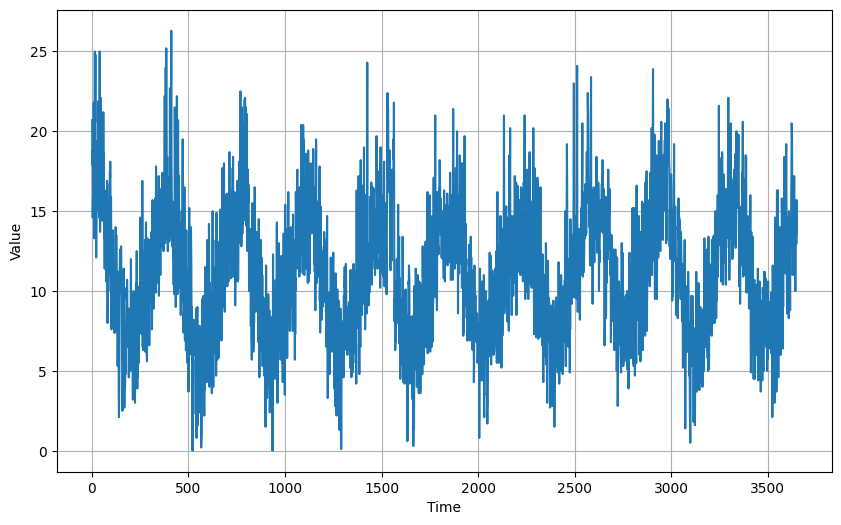

In [4]:
# we will iterate through te dataset getting time values and its corresponding temperature value
# then plot the series
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 1
  for row in reader:
    time_step.append(step)
    step += 1
    temps.append(float(row[1]))
#convert temps and time_step list into numpy array
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
#splitting our data into training and validation datasets for both time and series numpy arrays
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
#create a function that gives windowed set of training set (return the input training data to the model)
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
#create a function that create the windowed testing sets and get the prediction of input model using this set
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
# setting the main hyperparameters
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000
# getting the training set using windowed_dataset function
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
#set the main architecture of our model
model = tf.keras.models.Sequential([
    #convolutional layer
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    #RNN layers
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64,return_sequences=True),
    #DNN layers
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
    #output layer
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
#complile our model
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#train our model
history = model.fit(train_set,epochs=100)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100
25/25 [==============================] - 15s 331ms/step - loss: 7.7970 - mae: 8.2738
Epoch 2/100
25/25 [==============================] - 6s 216ms/step - loss: 2.8845 - mae: 3.3531
Epoch 3/100
25/25 [==============================] - 6s 217ms/step - loss: 2.8241 - mae: 3.2915
Epoch 4/100
25/25 [==============================] - 7s 281ms/step - loss: 2.7964 - mae: 3.2633
Epoch 5/100
25/25 [==============================] - 7s 266ms/step - loss: 2.7882 - mae: 3.2553
Epoch 6/100
25/25 [==============================] - 6s 214ms/step - loss: 2.7567 - mae: 3.2231
Epoch 7/100
25/25 [==============================] - 6s 219ms/step - loss: 2.7413 - mae: 3.2083
Epoch 8/100
25/25 [==============================] - 6s 214ms/step - loss: 2.7705 - mae: 3.2374
Epoch 9/100
25/25 [==============================] - 7s 242ms/

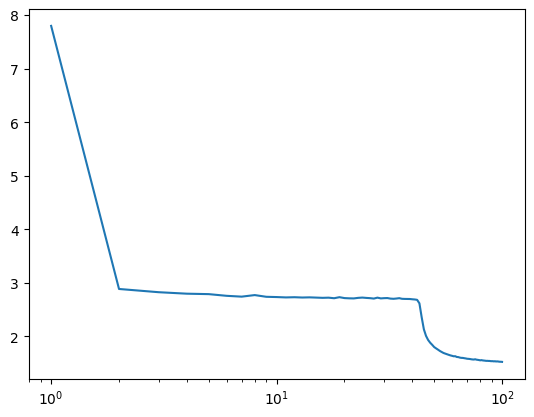

In [25]:
#plotting the loss values through out the 100 epochs
plt.semilogx(np.array(range(1,101)), history.history["loss"])

In [26]:
#getting a forcasting values using model_forecast function using our model and creating a testing set
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
#slicing our predicted values
rnn_forecast = rnn_forecast[split_time - window_size: -1,-1 , 0]

113/113 [==============================] - 5s 36ms/step


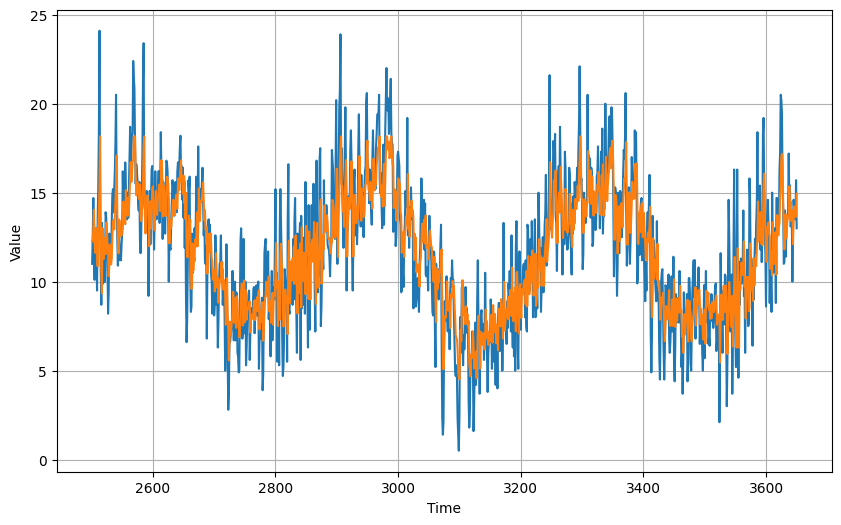

In [27]:
#plotting the true and predicted values with each other
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
#calculating the mean square error of our model
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7844654